In [1]:
import pandas as pd
import re

# Chemin vers le fichier texte
fichier_texte = 'train.txt'

# Liste pour stocker les données
data = []

# Lecture du fichier texte
with open(fichier_texte, 'r', encoding='utf-8') as f:
    for ligne in f:
        # Extraction du label et du texte
        match = re.match(r"(\d+)\s+(.*)", ligne)
        if match:
            label = int(match.group(1))
            texte = match.group(2)
            data.append({"label": label, "texte": texte})

# Création du DataFrame
df = pd.DataFrame(data)

# Enregistrement en CSV
df.to_csv('output.csv', index=False, encoding='utf-8')
print("Fichier CSV créé : output.csv")
df

Fichier CSV créé : output.csv


,label,texte
0,4,Catheterization laboratory events and hospital...
1,5,Renal abscess in children. Three cases of rena...
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,5,Subclavian artery to innominate vein fistula a...
4,4,Effect of local inhibition of gamma-aminobutyr...
...,...,...
14433,4,Quadricuspid aortic valve and aortic regurgita...
14434,1,Mammographic measurements before and after aug...
14435,1,Use of leukocyte-depleted platelet concentrate...
14436,2,Complications of Tenckhoff catheters post remo...


In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
import os

# Désactiver Weights & Biases si tu ne souhaites pas l'utiliser
os.environ["WANDB_DISABLED"] = "true"

# Charger le tokenizer et le modèle
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1", num_labels=5)

# Rendre les paramètres du modèle contigus pour éviter l'erreur de non-contiguïté
for param in model.parameters():
    param.data = param.data.contiguous()

# Chargement de ton DataFrame (assure-toi qu'il contient les colonnes "label" et "texte")


# Ajuster les labels pour qu'ils commencent à 0
df["label"] = df["label"] - 1  # Si les labels sont de 1 à 5, cela les transforme en 0 à 4

# Diviser le DataFrame en ensembles d'entraînement et de test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convertir les DataFrames en datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Fonction de prétraitement avec padding et troncation
def preprocess_function(examples):
    return tokenizer(examples["texte"], padding="max_length", truncation=True, max_length=512)

# Appliquer la fonction de prétraitement sur les datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Créer un DatasetDict pour le Trainer
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# Création du collateur de données avec padding dynamique
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Configurer les paramètres d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    run_name="BioBERT_fine_tuning",  # Donne un nom spécifique pour cette exécution
    eval_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    report_to="none"  # Désactiver les rapports W&B
)

# Mise en place du Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator  # Utilisation du collateur avec padding dynamique
)

# Entraîner le modèle
trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoin

Map:   0%|          | 0/11550 [00:00<?, ? examples/s]

Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.830900,0.776837


TrainOutput(global_step=2888, training_loss=0.921275902322785, metrics={'train_runtime': 1342.6853, 'train_samples_per_second': 8.602, 'train_steps_per_second': 2.151, 'total_flos': 3039014545459200.0, 'train_loss': 0.921275902322785, 'epoch': 1.0})

Accuracy: 0.67


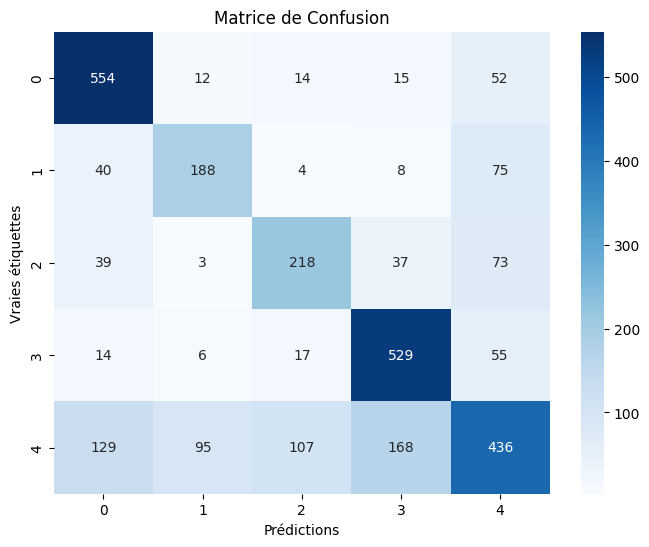

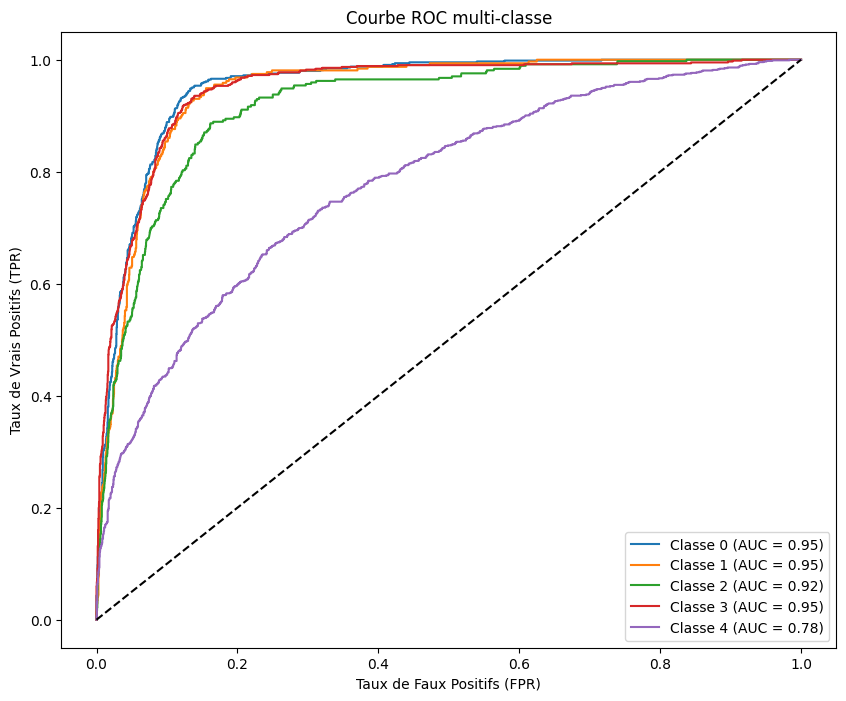

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Récupérer les prédictions
predictions = trainer.predict(dataset["test"])
y_true = np.array(dataset["test"]["label"])
y_pred = np.argmax(predictions.predictions, axis=1)

# 1. Calculer l'accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# 2. Tracer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion')
plt.show()

# 3. Tracer la courbe ROC pour chaque classe
y_true_binarized = label_binarize(y_true, classes=range(5))
y_score = predictions.predictions

# Initialisation des variables pour les courbes ROC multi-classes
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

# Tracer la diagonale (aléatoire)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC multi-classe')
plt.legend(loc="lower right")
plt.show()


In [4]:
from sklearn.metrics import accuracy_score
import numpy as np

# Récupérer les prédictions du modèle sur l'ensemble de test
predictions = trainer.predict(dataset["test"])
y_true = np.array(dataset["test"]["label"])  # Labels réels
y_pred = np.argmax(predictions.predictions, axis=1)  # Labels prédits
print(np.array(dataset["test"]["label"]))
# Calculer l'accuracy
accuracy = accuracy_score(y_true, y_pred)
print(trainer.predict(dataset["test"]))
print(f"Accuracy: {accuracy:.2f}")


[4 0 4 ... 1 3 4]


PredictionOutput(predictions=array([[-0.84182155, -1.4251152 ,  1.143567  , -1.6553272 ,  2.7021549 ],
       [ 0.8014716 , -2.1600292 ,  2.3316548 , -1.46362   ,  1.1140839 ],
       [-1.6888176 , -2.1923602 ,  2.4471827 , -0.8786859 ,  2.1540387 ],
       ...,
       [-0.5584095 ,  1.6197051 , -1.5623943 , -1.9179844 ,  2.1189256 ],
       [-2.6142066 , -2.3053026 , -1.0452826 ,  3.2036633 ,  1.3598285 ],
       [-1.2305872 , -1.181571  , -0.8212202 , -0.19962306,  3.4271028 ]],
      dtype=float32), label_ids=array([4, 0, 4, ..., 1, 3, 4]), metrics={'test_loss': 0.7768365144729614, 'test_runtime': 88.0007, 'test_samples_per_second': 32.818, 'test_steps_per_second': 8.204})
Accuracy: 0.67


In [5]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
